# A Graph Theory Approach to Algorithmic Trading Based on Millington and Niranjan (2020)

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
from scipy.linalg import expm
from sklearn.covariance import LedoitWolf

## Step 1: Get Official Holdings

In [2]:
def list_spy_holdings() -> pd.DataFrame:
    # Source: https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-500-etf-trust-spy
    url = 'https://www.ssga.com/us/en/intermediary/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'

    # Read the excel file directly from the URL
    # Requires 'openpyxl'
    return pd.read_excel(url, engine='openpyxl', index_col='Ticker', skiprows=4).dropna()

print("Fetching official S&P 500 holdings from SSGA...")

try:
    spy_holdings = list_spy_holdings()

    # Convert index to list and filter out 'CASH_USD' or other non-equity placeholders
    tickers = [t for t in spy_holdings.index.tolist() if isinstance(t, str) and "-" not in t]

    # YFinance expects hyphens for classes (e.g., BRK-B) instead of dots (BRK.B)
    tickers = [t.replace('.', '-') for t in tickers]

    print(f"Successfully retrieved {len(tickers)} tickers.")
    dataset_name = "S&P 500 Network - Top 100 Correlations"

except:
    print(f"Error fetching S&P 500 holdings. Using sample set.")
    # Fallback to top tech stocks if fetch fails
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
    dataset_name = "Magnificent 7 Network"

Fetching official S&P 500 holdings from SSGA...
Successfully retrieved 503 tickers.


## Step 2: Data Download and Processing

This step is based on https://doi.org/10.1007/s41109-020-0251-z [1]. Personally, I disagree with their methodology:

*   Using today's S&P 500 list to simulate 20 years of history introduces survivorship bias because you are predicting the future: you are only including companies that were robust enough to survive until the present day. Using backward fill for data missing at the start is also cheating. It assumes you knew the price of a stock before it started trading. The fix is to build a new graph for every window based only on the S&P 500 constituents at the time. I haven't done this yet because it is extraordinarily painful to find a complete list of historical S&P companies without paying.
*   "Since **financial data is non stationary** we use a window of **300 days** and slide along this 30 days at a time to obtain a sample where **we can assume the data is stationary**, giving us 140 windows overall." Bruh
*   Apparently, there are also some problems with using Ledoit-Wolf shrinkage, and I am told to use RMT to obtain partial correlation instead(https://quant.stackexchange.com/questions/2207/cleansing-covariance-matrices-via-random-matrix-theory). I'll get to that later.



In [3]:
start_date = "2024-01-01"
end_date = "2026-01-01"

# Benchmark Data (S&P 500)
print("Downloading S&P 500 (^GSPC) data...")
sp500 = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']

sp500_log_ret = sp500.replace([np.inf, -np.inf], np.nan)
sp500_log_ret = np.log(sp500 / sp500.shift(1)).dropna()

# Download adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']

# Drop columns (tickers) with more than 10% missing data
data = data.dropna(axis=1, thresh=int(data.shape[0] * 0.9))

# Fill remaining gaps (ffill with price from previous day, then bfill from first day traded if missing from start)
data = data.ffill().bfill()

log_returns = np.log(data / data.shift(1))
log_returns = log_returns.replace([np.inf, -np.inf], np.nan)
log_returns = log_returns.dropna()

In [4]:
window_size = 300
step_size = 30
normalized_windows = []
network_matrices = []

# Calculate total number of rows to loop through
n_samples = log_returns.shape[0]

print(f"Starting sliding window analysis on {n_samples} days of data...")

# Loop: Start at 0, stop before we run out of data, step by 30
for i in range(0, n_samples - window_size + 1, step_size):

    # Get rows i to i+300
    window_data = log_returns.iloc[i : i + window_size]
    window_mean = window_data.mean()
    window_std = window_data.std()

    # Handle division by zero (if a stock was flat for 300 days)
    # Replace 0 std with 1 to keep value as 0 (Mean) instead of NaN
    window_std = window_std.replace(0, 1)

    # Z-Score Normalization
    normalized_window = (window_data - window_mean) / window_std

    # Ledoit-Wolf Shrinkage
    lw = LedoitWolf()
    lw.fit(normalized_window)

    # The 'covariance_' attribute is the shrunk covariance matrix
    shrunk_cov = lw.covariance_

    # The 'precision_' attribute is the inverse (for partial correlation)
    shrunk_prec = lw.precision_

    # Calculate Standard Pearson Correlation
    pearson_corr = window_data.corr()

    # Convert Covariance to Correlation
    # C_ij = Sigma_ij / sqrt(Sigma_ii * Sigma_jj)
    d_cov = np.diag(shrunk_cov)
    denom_cov = np.sqrt(np.outer(d_cov, d_cov))
    shrunk_corr = shrunk_cov / denom_cov

    # Convert Precision to Partial Correlation
    # rho_ij = - p_ij / sqrt(p_ii * p_jj)
    d_prec = np.diag(shrunk_prec)
    denom_prec = np.sqrt(np.outer(d_prec, d_prec))
    partial_corr = -shrunk_prec / denom_prec
    np.fill_diagonal(partial_corr, 1.0)

    # Store Results
    window_tickers = window_data.columns
    res = {
        "start_date": window_data.index[0],
        "end_date": window_data.index[-1],
        "covariance": pd.DataFrame(shrunk_cov, index=window_tickers, columns=window_tickers),
        "pearson_corr": pd.DataFrame(pearson_corr, index=window_tickers, columns=window_tickers),
        "shrunk_corr": pd.DataFrame(shrunk_corr, index=window_tickers, columns=window_tickers),
        "partial_corr": pd.DataFrame(partial_corr, index=window_tickers, columns=window_tickers),
        "shrinkage_coeff": lw.shrinkage_
    }
    network_matrices.append(res)

print(f"Processed {len(network_matrices)} windows.")
print(f"Last Window Shrinkage Coefficient: {network_matrices[-1]['shrinkage_coeff']:.4f}")

Starting sliding window analysis on 501 days of data...
Processed 7 windows.
Last Window Shrinkage Coefficient: 0.0965


## Step 3: Network Construction and Visualization

Following [1], we construct full weighted graphs using the above correlation matrices.

Plotting networks for window: 2024-01-03 to 2025-03-14


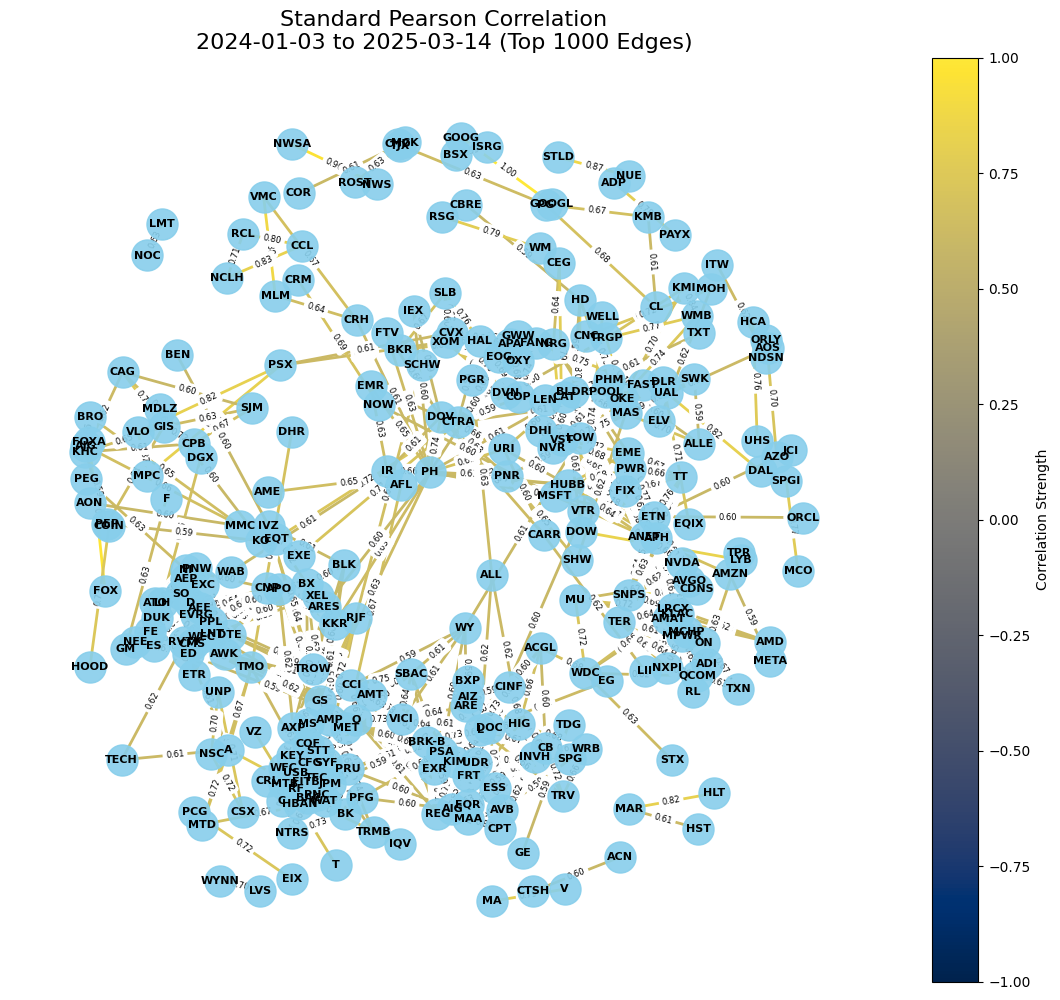

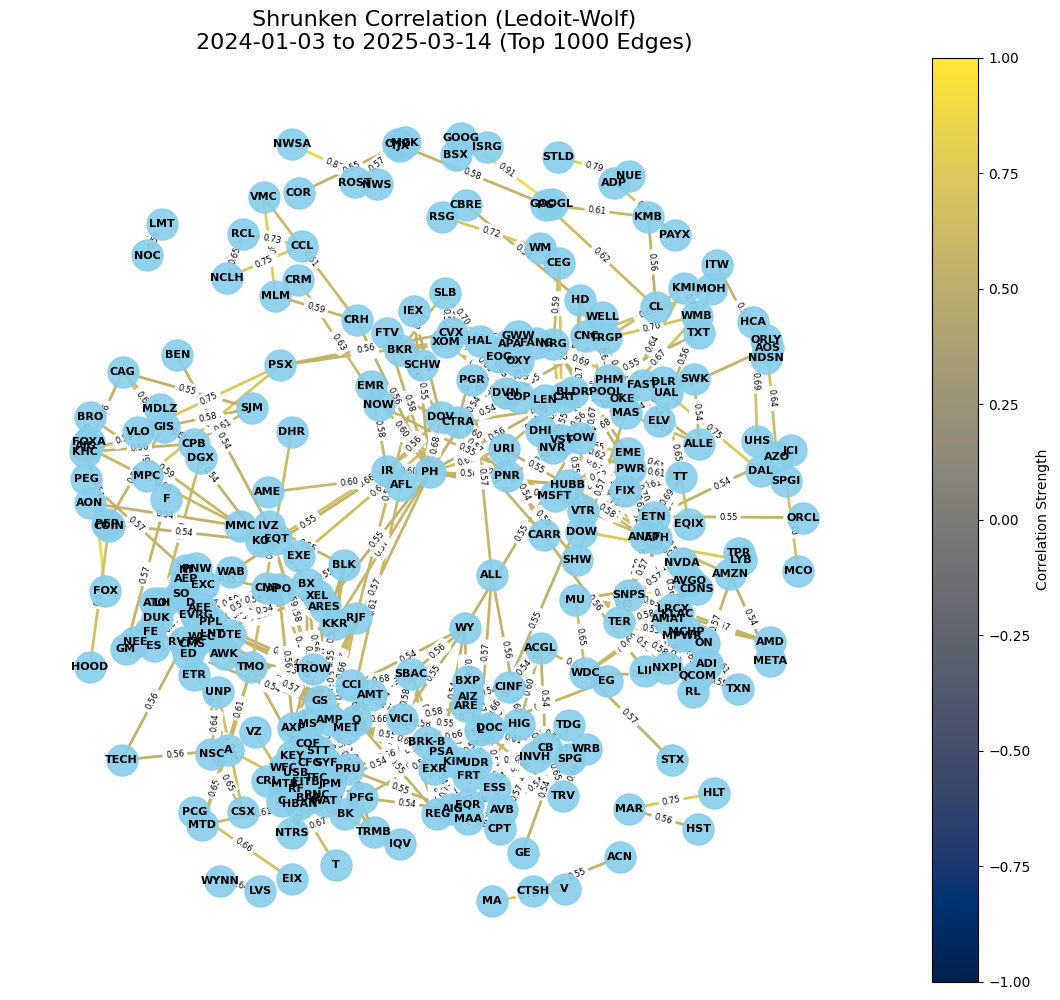

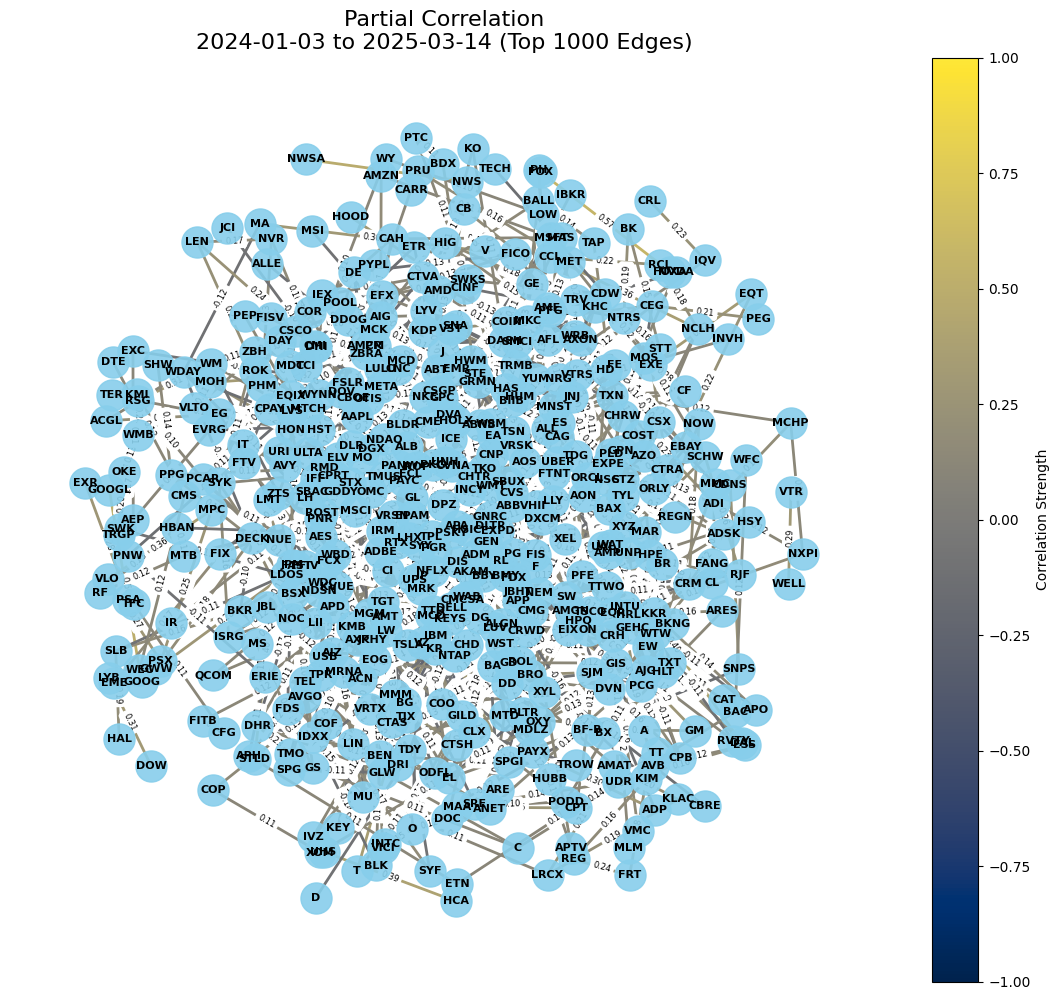

In [5]:
def plot_network(corr_matrix, title, top_n=1000):
    # Mask upper triangle to avoid duplicates and self-loops
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_masked = corr_matrix.where(mask)

    # Flatten to an edge list
    series_corr = corr_masked.stack()
    series_corr.index.names = ['Source', 'Target']
    edges = series_corr.reset_index()
    edges.columns = ['Source', 'Target', 'Weight']

    # Sort by strongest absolute correlations
    edges_sorted = edges.reindex(edges['Weight'].abs().sort_values(ascending=False).index)
    top_edges = edges_sorted.head(top_n)

    # Build Graph
    G = nx.from_pandas_edgelist(top_edges, 'Source', 'Target', ['Weight'])

    # Create a new figure
    plt.figure(figsize=(14, 12))

    # Spring layout tries to cluster highly correlated nodes closer together
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.9)

    # Draw Edges with Spectrum
    weights = [d['Weight'] for (u, v, d) in G.edges(data=True)]

    # Note: vmin/vmax set to -1 and 1 to keep the color scale consistent across plots
    edges_drawn = nx.draw_networkx_edges(
        G, pos,
        width=2,
        edge_color=weights,
        edge_cmap=plt.cm.cividis,
        edge_vmin=-1.0,
        edge_vmax=1.0
    )

    # Draw Node Labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Draw Edge Labels (Weights) - Optional: can comment out if too cluttered
    edge_labels = {(u, v): f"{d['Weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='black')

    plt.title(f"{title} (Top {top_n} Edges)", fontsize=16)
    plt.axis('off')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=plt.Normalize(vmin=-1.0, vmax=1.0))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Correlation Strength')

# Execute Plots

# Get the data from the first window
first_window = network_matrices[0]
date_info = f"{first_window['start_date'].date()} to {first_window['end_date'].date()}"

print(f"Plotting networks for window: {date_info}")

# Standard Pearson
plot_network(first_window['pearson_corr'], f"Standard Pearson Correlation\n{date_info}")

# Shrunken Correlation
plot_network(first_window['shrunk_corr'], f"Shrunken Correlation (Ledoit-Wolf)\n{date_info}")

# Partial Correlation
plot_network(first_window['partial_corr'], f"Partial Correlation\n{date_info}")

plt.show()

## Step 4: Local Mispricings using Laplacian Diffusion

Based on https://doi.org/10.1007/s10114-004-0437-9 [2] and https://doi.org/10.1137/1.9781611972801 [3]. Because the full partial correlation matrix includes many weak and noisy edges that will dilute the signal, we choose to keep only the top $X\%$ of edges by absolute weight. Other methods to sparsify the network are also possible, such as a community-preserving filter, the graphical lasso, etc. Personally, I don't know enough statistics to tell you which one is best or if they even apply in this context. I'm probably just gonna implement as many as I can think of and then backtest to choose.

One problem that arises in the particular case of using a multiscale, community-preserving filter is the fact that partial correlation networks are less successful than correlation networks in uncovering sector clusters using a Louvain community detection algorithm [1]. The copium is that I am trying to detect mispricings in the stock market, not trying to recover stock market sectors. Sectors are public knowledge, which is already priced in. What remains after removing sector and market effects are the idiosyncratic, temporary, cross-sector relationships that might contain alpha.

In [6]:
# Thresholding
def threshold_matrix(corr_matrix, percentile=90):
    flat = corr_matrix.values.flatten()
    threshold = np.percentile(np.abs(flat), percentile)
    adj = corr_matrix.copy()
    adj[np.abs(adj) < threshold] = 0
    np.fill_diagonal(adj.values, 0)  # Remove self-loops
    return adj

# Community-preserving Filter
def get_signed_communities(adj_matrix, max_iter=100):
    """
    Detect communities using a modified Louvain community detection algorithm
    (Greedy optimization of Signed Modularity).
    """
    n = len(adj_matrix)
    np.fill_diagonal(adj_matrix.values, 0) # Don't sum self-loops

    # Prepare Positive and Negative Matrices
    A_plus = np.maximum(adj_matrix, 0)
    A_minus = np.maximum(-adj_matrix, 0)

    # Calculate constants (m+, m-, m_total)
    m_plus = A_plus.values.sum()
    m_minus = A_minus.values.sum()
    m_total = m_plus + m_minus

    # Calculate Weights for Signed Modularity
    if m_total == 0: # Handle zero case
        w_plus = 0
        w_minus = 0
    else:
        w_plus = m_plus / m_total
        w_minus = m_minus / m_total

    # Calculate Degrees
    k_plus = np.sum(A_plus, axis=1)
    k_minus = np.sum(A_minus, axis=1)

    # Initialize each node in its own community
    communities = np.arange(n)
    node_indices = np.arange(n)

    for i in range(max_iter):
        improvement = False
        # Randomize node order
        np.random.shuffle(node_indices)

        for node in node_indices:
            current_comm = communities[node]

            # Identify neighbours (nodes connected by + or - edges)
            row_plus = A_plus.iloc[node].values
            row_minus = A_minus.iloc[node].values
            neighbours = np.where((row_plus > 0) | (row_minus > 0))[0]

            # Get unique communities of neighbors and the current community
            candidate_nodes = np.append(neighbours, node)
            candidate_comms = np.unique(communities[candidate_nodes])

            best_gain = -np.inf
            best_comm = current_comm

            # Calculate current node parameters
            k_i_plus = k_plus.iloc[node]
            k_i_minus = k_minus.iloc[node]

            for target_comm in candidate_comms:
                # Identify members of the target community
                members_mask = (communities == target_comm)

                # Check if we are calculating for the current community
                # (Logic: If node is already in target_comm, we calculate contribution as is.
                #  If node moves to new comm, we calculate what contribution WOULD be)

                # Sum of weights from node i to members of target community
                k_i_in_plus = np.sum(A_plus.iloc[node].values[members_mask])
                k_i_in_minus = np.sum(A_minus.iloc[node].values[members_mask])

                # Sum of degrees of all members in target community
                sigma_tot_plus = np.sum(k_plus.values[members_mask])
                sigma_tot_minus = np.sum(k_minus.values[members_mask])

                # dQ formula terms
                # Subtract the node's own degree from sigma to avoid "stay at home" bias
                if target_comm == current_comm:
                    eff_sigma_plus = sigma_tot_plus - k_i_plus
                    eff_sigma_minus = sigma_tot_minus - k_i_minus
                else:
                    eff_sigma_plus = sigma_tot_plus
                    eff_sigma_minus = sigma_tot_minus

                if m_plus == 0:
                    dq_plus = 0
                else:
                    dq_plus = (2 * k_i_in_plus / m_plus) - (2 * eff_sigma_plus * k_i_plus) / (m_plus**2)

                if m_minus == 0:
                    dq_minus = 0
                else:
                    dq_minus = (2 * k_i_in_minus / m_minus) - (2 * eff_sigma_minus * k_i_minus) / (m_minus**2)

                dq = (w_plus * dq_plus) - (w_minus * dq_minus)

                if dq > best_gain:
                    best_gain = dq
                    best_comm = target_comm

            if best_comm != current_comm:
                communities[node] = best_comm
                improvement = True

        # Stop if no nodes moved in a full pass
        if not improvement:
            break

    return communities

def community_preserving_filter(corr_matrix, communities, min_intra=0.1, min_inter=0.25):
    # Keeps weaker edges within communities, but only strong edges between communities
    corr_values = corr_matrix.values
    comm_mask = (communities[:, None] == communities[None, :]) # Broadcasting

    dynamic_thresholds = np.where(comm_mask, min_intra, min_inter)
    filtered_adj = np.where(np.abs(corr_values) > dynamic_thresholds, corr_values, 0)
    np.fill_diagonal(filtered_adj, 1.0)

    return pd.DataFrame(filtered_adj, index=corr_matrix.index, columns=corr_matrix.columns)

# Construct the diffusion kernel (e^-tau*L) from an adjacency matrix
def diffusion_kernel(adj_raw, method='community', tau=0.1, repeat=10):
    # Choose the Filtering Method
    if method == 'threshold':
        # Method A: Simple Global Threshold (e.g., Top 10% strongest links)
        adj = threshold_matrix(adj_raw, percentile=90)

    elif method == 'community':
        # Method B: Smart Community Filter (Weak links kept if internal, Strong links required if external)
        ensemble_adj = np.zeros_like(adj_raw.values, dtype=float)

        for i in range(repeat):
          # Detect Communities (Random Seed changes each time)
          communities = get_signed_communities(adj_raw)

          # Filter the matrix based on these communities
          single_adj = community_preserving_filter(adj_raw, communities, min_intra=0.1, min_inter=0.25).values

          ensemble_adj += single_adj

        # Average out fluctuations due to Louvain algorithm
        adj_values = ensemble_adj / repeat
        adj = pd.DataFrame(adj_values, index=adj_raw.index, columns=adj_raw.columns)

    else:
        raise ValueError("Method must be 'threshold' or 'community'")

    # Build Laplacian
    valid_tickers = adj.index
    A = adj.values

    degrees_abs = np.sum(np.abs(A), axis=1)
    D_abs = np.diag(degrees_abs)
    Ls = D_abs - A

    # 3. Compute Exponential (The Expensive Step)
    kernel = expm(-tau * Ls)

    return kernel, valid_tickers

# Estimate residuals using signed Laplacian diffusion
def get_residuals(returns_df, kernel, valid_tickers):
    # Align data by checking which tickers from the network are actually present in the daily returns
    available_tickers = valid_tickers.intersection(returns_df.columns)
    s_actual = returns_df[available_tickers].values
    indexer = valid_tickers.get_indexer(available_tickers)
    kernel_sliced = kernel[np.ix_(indexer, indexer)]

    # Diffuse
    s_expected = s_actual @ kernel_sliced.T

    # Compute residuals
    residuals = s_actual - s_expected

    return pd.DataFrame(residuals, index=returns_df.index, columns=available_tickers)

def compute_aggregated_signals(return_slice, kernel, valid_tickers, agg_type='ewma'):
    # Calculate all residuals at once
    signal_df = get_residuals(return_slice, kernel, valid_tickers)

    # Aggregate
    if agg_type == 'median':
        return signal_df.median()

    elif agg_type == 'ewma':
        # (Half-life of 5 days approx alpha=0.13)
        return signal_df.ewm(span=10).mean().iloc[-1]

    else: # 'mean'
        return signal_df.mean()

# Compare Methods
last_window = network_matrices[-1]
last_day_returns = log_returns.iloc[-1:].copy()

matrices = {
    "Standard Pearson": last_window['pearson_corr'],
    "Shrunken": last_window['shrunk_corr'],
    "Partial Correlation": last_window['partial_corr']
}

for name, matrix_raw in matrices.items():
    print(f"\n================= {name.upper()} =================")

    # Method 1: Simple Threshold
    k_thresh, t_thresh = diffusion_kernel(matrix_raw, method='threshold', tau=0.1)
    res_thresh_df = get_residuals(last_day_returns, k_thresh, t_thresh)
    res_thresh = res_thresh_df.iloc[0]

    # Method 2: Community Filter
    k_comm, t_comm = diffusion_kernel(matrix_raw, method='community', tau=0.1)
    res_comm_df = get_residuals(last_day_returns, k_comm, t_comm)
    res_comm = res_comm_df.iloc[0]

    # Compare Shorts (Overvalued)
    print(f"\n--- Top 3 Shorts (Overvalued) ---")
    df_short = pd.DataFrame({
        'Threshold_Ticker': res_thresh.nlargest(3).index,
        'Thresh_Val': res_thresh.nlargest(3).values,
        'Community_Ticker': res_comm.nlargest(3).index,
        'Comm_Val': res_comm.nlargest(3).values
    })
    print(df_short)

    # Compare Longs (Undervalued)
    print(f"\n--- Top 3 Longs (Undervalued) ---")
    df_long = pd.DataFrame({
        'Threshold_Ticker': res_thresh.nsmallest(3).index,
        'Thresh_Val': res_thresh.nsmallest(3).values,
        'Community_Ticker': res_comm.nsmallest(3).index,
        'Comm_Val': res_comm.nsmallest(3).values
    })
    print(df_long)


================= STANDARD PEARSON =================

--- Top 3 Shorts (Overvalued) ---
  Threshold_Ticker  Thresh_Val Community_Ticker  Comm_Val
0              NKE    0.021264              NKE  0.048867
1              UAL    0.012357              MOH  0.023792
2              BEN    0.010828              TDG  0.018589

--- Top 3 Longs (Undervalued) ---
  Threshold_Ticker  Thresh_Val Community_Ticker  Comm_Val
0              HPQ   -0.017577             FICO -0.023560
1              GPN   -0.014003              UHS -0.023371
2               MU   -0.013886             MRNA -0.022181

================= SHRUNKEN =================

--- Top 3 Shorts (Overvalued) ---
  Threshold_Ticker  Thresh_Val Community_Ticker  Comm_Val
0              NKE    0.019707              NKE  0.048957
1              UAL    0.012358              MOH  0.023140
2              BEN    0.010812              TDG  0.018630

--- Top 3 Longs (Undervalued) ---
  Threshold_Ticker  Thresh_Val Community_Ticker  Comm_Val
0     

## Step 5: Backtest

We implement a robust walk-forward backtesting framework to simulate the historical performance of the above trading strategy. It constructs a portfolio by ranking stocks based on their residuals, going Long the bottom decile and Short the top decile, and then calculates the Information Coefficient for every window, providing a statistical measure of how well the residuals predicted future returns.

We choose to run our backtest with shrunken correlation instead of partial correlation because the network plot for partial correlation looks like garbage. This is most likely due to numerical instability when inverting the covariance matrix. I will fix that at another time.

Settings: Lookback=20d | Agg=ewma | Method=community | Tau=0.1


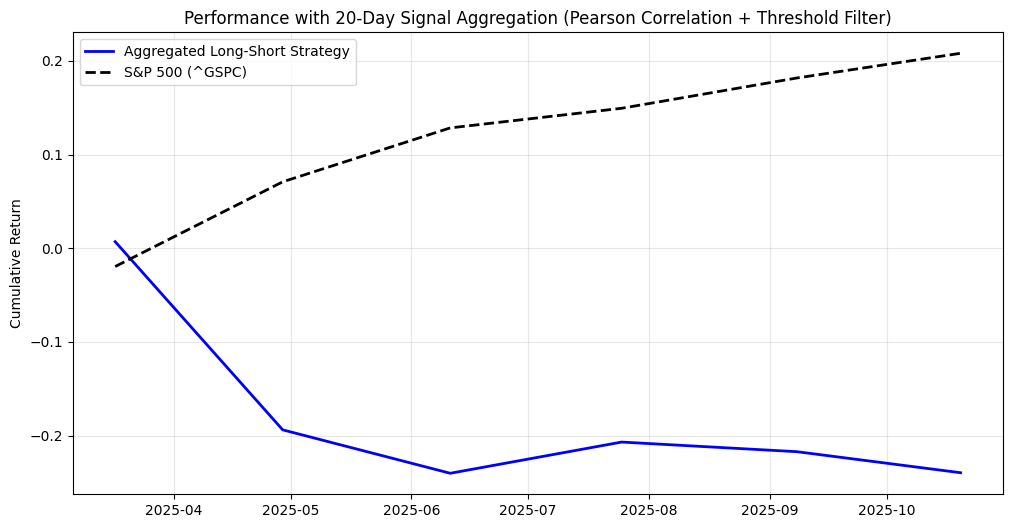

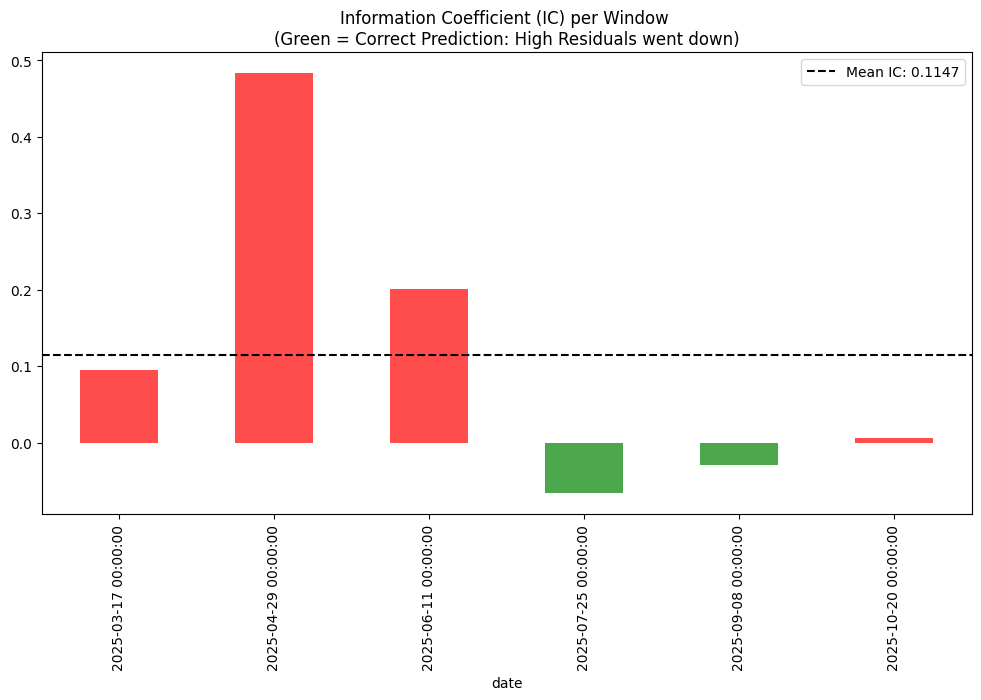

Mean Monthly Return: -0.0457
Mean IC: 0.1147
IC T-Stat: 1.37 (p-value: 0.2278)


In [7]:
def backtest_strategy(returns_df, benchmark_returns, network_matrices, window_size, step_size, matrix_type='partial_corr', method='community', lookback=20, agg_type='ewma', tau=0.1, repeat=10):
    """
    Robust backtest preventing look-ahead bias.

    Args:
        returns_df: Full DataFrame of log returns
        network_matrices: List of dicts containing 'partial_corr'
        window_size: Size of rolling window (e.g., 300 days)
        step_size: Size of holding period (e.g., 30 days)
    """
    portfolio_results = []
    ic_series = [] # Information Coefficients

    print(f"Settings: Lookback={lookback}d | Agg={agg_type} | Method={method} | Tau={tau}")

    # Note: network_matrices[i] corresponds to the window ending at index (i*step + window)
    for i in range(len(network_matrices) - 1):

        # Timing & Data Slicing
        # Training Data (for Signal)
        train_start = i * step_size
        train_end = train_start + window_size

        # Test Data (for Trading)
        test_start = train_end
        test_end = min(test_start + step_size, len(returns_df))

        if test_start >= len(returns_df):
            break

        # Current Trading Dates
        current_dates = returns_df.index[test_start:test_end]

        # Build map
        raw_network = network_matrices[i][matrix_type]
        kernel, valid_tickers = diffusion_kernel(raw_network, method=method, tau=tau, repeat=10)

        # Signal Generation
        lookback_slice = returns_df.iloc[train_end - lookback : train_end]

        signals = compute_aggregated_signals(
            lookback_slice,
            kernel,
            valid_tickers,
            agg_type=agg_type
        )

        # Define Weighted Portfolio
        n_stocks = len(signals)
        decile_count = int(n_stocks * 0.1)

        long_stocks = signals.nsmallest(decile_count)
        short_stocks = signals.nlargest(decile_count)

        long_weights = long_stocks.abs() / long_stocks.abs().sum()
        short_weights = short_stocks.abs() / short_stocks.abs().sum()

        # Track Returns
        future_ret = returns_df.iloc[test_start:test_end].sum()
        long_ret = (future_ret[long_stocks.index] * long_weights).sum()
        short_ret = (future_ret[short_stocks.index] * short_weights).sum()

        # Convert to simple returns
        future_simple_ret = np.exp(returns_df.iloc[test_start:test_end].sum()) - 1
        long_simple_ret = (future_simple_ret[long_stocks.index] * long_weights).sum()
        short_simple_ret = (future_simple_ret[short_stocks.index] * short_weights).sum()

        # Benchmark Returns (S&P 500)
        period_benchmark = benchmark_returns.reindex(current_dates).fillna(0).sum().iloc[0]

        # Strategy: Long - Short (Market Neutral assumption)
        strategy_ret = np.log(1 + (long_simple_ret - short_simple_ret))

        portfolio_results.append({
            'window_id': i,
            'date': returns_df.index[test_start],
            'long': long_ret,
            'short': -short_ret, # Profit if they fall
            'strategy': strategy_ret,
            'sp500': period_benchmark
        })

        # Statistical Validation
        common_index = signals.index.intersection(future_ret.index)
        ic = signals.loc[common_index].corr(future_ret.loc[common_index], method='spearman')
        ic_series.append(ic)

    return pd.DataFrame(portfolio_results).set_index('date'), pd.Series(ic_series)

results_df, ic_series = backtest_strategy(
    log_returns,
    sp500_log_ret,
    network_matrices,
    window_size=300,
    step_size=30,
    matrix_type='shrunk_corr',
    method='community',
    lookback=20,
    agg_type='ewma',
    tau=0.1,
    repeat=10
)

# Visualizations

# Cumulative Returns
plt.figure(figsize=(12, 6))
# Convert log returns to cumulative simple returns for display
df_cum = np.exp(results_df[['long', 'short', 'strategy', 'sp500']].cumsum()) - 1
plt.plot(df_cum['strategy'], label='Aggregated Long-Short Strategy', linewidth=2, color='blue')
plt.plot(df_cum['sp500'], label='S&P 500 (^GSPC)', linewidth=2, color='black', linestyle='--')
plt.title(f"Performance with 20-Day Signal Aggregation (Pearson Correlation + Threshold Filter)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Signal Quality (IC)
plt.figure(figsize=(12, 6))
ic_by_date = pd.Series(ic_series.values, index=results_df.index)
ax = ic_by_date.plot(kind='bar', color=np.where(ic_by_date < 0, 'green', 'red'), alpha=0.7)
plt.axhline(ic_by_date.mean(), color='black', linestyle='--', label=f'Mean IC: {ic_by_date.mean():.4f}')
plt.title("Information Coefficient (IC) per Window \n(Green = Correct Prediction: High Residuals went down)")
plt.legend()
plt.show()

# Statistics
t_stat, p_val = stats.ttest_1samp(ic_series, 0)
print(f"Mean Monthly Return: {results_df['strategy'].mean():.4f}")
print(f"Mean IC: {ic_series.mean():.4f}")
print(f"IC T-Stat: {t_stat:.2f} (p-value: {p_val:.4f})")

Wonderful, this algorithm will make me a gazillionaire soon